# Parse the smiles and generate the 220k molecules. Export molecules into csv files

There are three ways doing this:
1. encode reactions in rdkit
2. remove the reaction fragment in components, and then the mols will be like "xx*", then combine them together at the * positions
3. Addbonds at specific atom numbers

Outputs:
1. the csv for 96 componenets, smiles and fragment smiles
2. the csv for 220k molecules, smiles and derived components

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Literal

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, rdMolEnumerator
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem.Draw import MolDrawing, DrawingOptions
from rdkit.Chem import PandasTools
from rdkit.Chem.Scaffolds import MurckoScaffold

IPythonConsole.ipython_useSVG = True
# support display images in pandas dataframe
PandasTools.RenderImagesInAllDataFrames(images=True)

warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)

### 1. read 96 raw smiles from csv

In [2]:
def show_atom_number(
    mol, label: Literal["atomLabel", "molAtomMapNumber", "atomNote"] = "atomNote"
):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))
    return mol

In [3]:
# core_smiles = "*C(=O)N(*)C(*)C(=O)N*"
core_smiles = "C(=O)NCC(=O)N"  # Connect at C0, N2, C3, N6
core_mol = Chem.MolFromSmiles(core_smiles)
core_num_atoms = core_mol.GetNumAtoms()
show_atom_number(core_mol)

core_A_pos = 2  # the position in core to attach component A
core_B_pos = 6  # the position in core to attach component B
core_C_pos = 3  # the position in core to attach component C
core_D_pos = 0  # the position in core to attach component D

In [4]:
data_file = Path("../../Chem_Doc/SMILES_96_4CR.csv")

mol_df = pd.read_csv(data_file)
assert len(mol_df.dropna(subset=["SMILES"]).drop_duplicates(subset=["SMILES"])) == len(mol_df)

# add a column to store the molecule object
mol_df["mol"] = mol_df["SMILES"].apply(Chem.MolFromSmiles).apply(show_atom_number)

# # add a column to store the scaffold
# mol_df["scaffold"] = mol_df["mol"].apply(MurckoScaffold.GetScaffoldForMol)

# # add a column to store the scaffold SMILES
# mol_df["scaffold_SMILES"] = mol_df["scaffold"].apply(Chem.MolToSmiles)

# add a column to store the molecular weight
mol_df["MW"] = mol_df["mol"].apply(Descriptors.MolWt)

# mol_df


In [5]:
# split the dataframe into four parts based on ID, (1) A*, (2) B*, (3) C*, (4) D*
mol_df["ID"] = mol_df["ID"].str.strip()
mol_df_A = mol_df[mol_df["ID"].str.startswith("A")]
mol_df_B = mol_df[mol_df["ID"].str.startswith("B")]
mol_df_C = mol_df[mol_df["ID"].str.startswith("C")]
mol_df_D = mol_df[mol_df["ID"].str.startswith("D")]

### 2.1. Structurize the df of component A, R1-NH2

In [6]:
# extract the -NH2 group from mol_df_A molecules
frag_NH2 = Chem.MolFromSmarts("[NH2]")
# mol_df_A["NH2"] = mol_df_A["mol"].apply(lambda x: Chem.MolFromSmarts("[NH2]"))
mol_df_A["NH2_pos"] = mol_df_A.apply(
    lambda x: x["mol"].GetSubstructMatch(frag_NH2), axis=1
)
# mol_df_A["main_compoent"] = mol_df_A["mol"].apply(
#     lambda x: Chem.DeleteSubstructs(x, frag_NH2)
# )

# replace the NH2 group with an open end atom *, that can later be connected to other molecules
mol_df_A["main_compoent"] = mol_df_A.apply(
    lambda x: Chem.ReplaceSubstructs(x["mol"], frag_NH2, Chem.MolFromSmiles("*"))[0],
    axis=1,
)
# renumbering
mol_df_A["main_compoent"] = mol_df_A["main_compoent"].apply(show_atom_number)

mol_df_A["main_compoent_SMILES"] = mol_df_A["main_compoent"].apply(Chem.MolToSmiles)
mol_df_A["main_num_atoms"] = mol_df_A["main_compoent"].apply(lambda x: x.GetNumAtoms())

,ID,Name,SMILES,mol,MW,NH2_pos,main_compoent,main_compoent_SMILES,main_num_atoms
0,A1,D5616,NCCN(C)C,,88.154,"(0,)",,*CCN(C)C,6
1,A2,A2241,NN1CCCCC1,,100.165,"(0,)",,*N1CCCCC1,7
2,A3,A0409,NCCCN1CCOCC1,,144.218,"(0,)",,*CCCN1CCOCC1,10

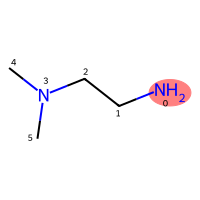
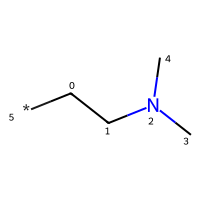
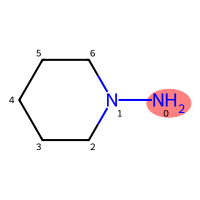
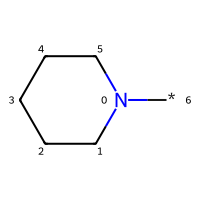
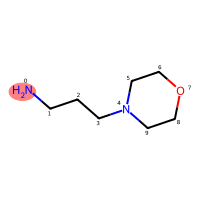
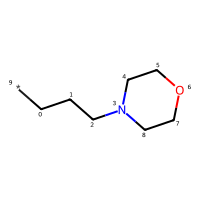

In [7]:
mol_df_A.head(3)

### 2.2. Structurize the df of component B, R2-NC

In [8]:
# extract the -NC group from mol_df_B molecules
frag_NC = Chem.MolFromSmarts("N#C")
# mol_df_B["NC"] = mol_df_B["mol"].apply(lambda x: Chem.MolFromSmarts("[NC]"))
mol_df_B["NC_pos"] = mol_df_B.apply(
    lambda x: x["mol"].GetSubstructMatch(frag_NC), axis=1
)
# mol_df_B["main_compoent"] = mol_df_B["mol"].apply(
#     lambda x: Chem.DeleteSubstructs(x, frag_NC)
# )

# replace the NC group with an open end atom *, that can later be connected to other molecules
mol_df_B["main_compoent"] = mol_df_B.apply(
    lambda x: Chem.ReplaceSubstructs(x["mol"], frag_NC, Chem.MolFromSmiles("*"))[0],
    axis=1,
)
# renumbering
mol_df_B["main_compoent"] = mol_df_B["main_compoent"].apply(show_atom_number)

mol_df_B["main_compoent_SMILES"] = mol_df_B["main_compoent"].apply(Chem.MolToSmiles)
mol_df_B["main_num_atoms"] = mol_df_B["main_compoent"].apply(lambda x: x.GetNumAtoms())


,ID,Name,SMILES,mol,MW,NC_pos,main_compoent,main_compoent_SMILES,main_num_atoms
32,B1,TRC-I289721,C[N+]#[C-],,41.053,"(1, 2)",,*C,2
33,B2,T1046,O=S(C[N+]#[C-])(C1=CC=C(C)C=C1)=O,,195.243,"(3, 4)",,*CS(=O)(=O)c1ccc(C)cc1,12
34,B3,I0455,[C-]#[N+]CN1C(C=CC=C2)=C2N=N1,,158.164,"(1, 0)",,*Cn1nnc2ccccc21,11

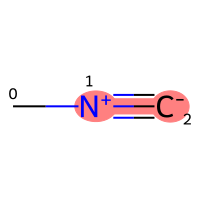
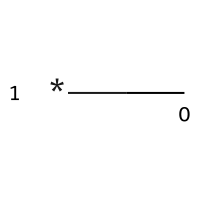
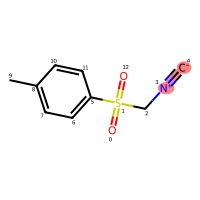
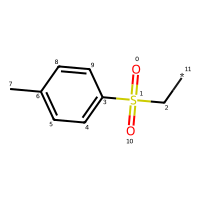
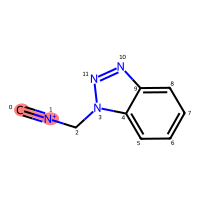
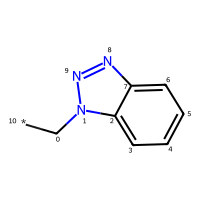

In [9]:
mol_df_B.head(3)

### 2.3. Structurize the df of component C, R3-CHO

In [10]:
# extract the -CHO group from mol_df_C molecules dd
frag_CHO = Chem.MolFromSmarts("[CX3H1](=O)")
# mol_df_C["CHO"] = mol_df_C["mol"].apply(lambda x: Chem.MolFromSmarts("[CX3H1](=O)"))
mol_df_C["CHO_pos"] = mol_df_C.apply(
    lambda x: x["mol"].GetSubstructMatch(frag_CHO), axis=1
)
# mol_df_C["main_compoent"] = mol_df_C["mol"].apply(
#     lambda x: Chem.DeleteSubstructs(x, frag_CHO)
# )

# replace the CHO group with an open end atom *, that can later be connected to other molecules
mol_df_C["main_compoent"] = mol_df_C.apply(
    lambda x: Chem.ReplaceSubstructs(x["mol"], frag_CHO, Chem.MolFromSmiles("*"))[0],
    axis=1,
)
# renumbering
mol_df_C["main_compoent"] = mol_df_C["main_compoent"].apply(show_atom_number)

mol_df_C["main_compoent_SMILES"] = mol_df_C["main_compoent"].apply(Chem.MolToSmiles)
mol_df_C["main_num_atoms"] = mol_df_C["main_compoent"].apply(lambda x: x.GetNumAtoms())

,ID,Name,SMILES,mol,MW,CHO_pos,main_compoent,main_compoent_SMILES,main_num_atoms
44,C1,H0133,CCCCCC=O,,100.161,"(5, 6)",,*CCCCC,6
45,C2,H0025,CCCCCCC=O,,114.188,"(6, 7)",,*CCCCCC,7
46,C3,O0044,CCCCCCCC=O,,128.215,"(7, 8)",,*CCCCCCC,8

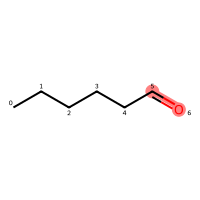
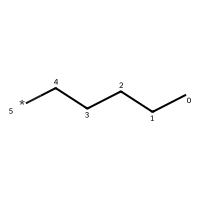
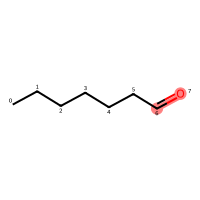
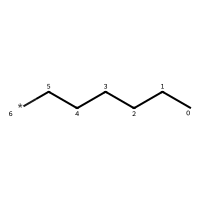
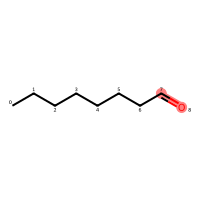
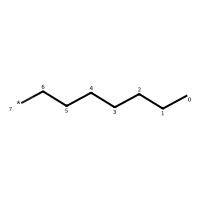

In [11]:
mol_df_C.head(3)

### 2.4. Structurize the df of component D, R4-COOH

In [12]:
# extract the -COOH group from mol_df_D molecules
frag_COOH = Chem.MolFromSmarts("[CX3](=O)[OX2H1]")
# mol_df_D["COOH"] = mol_df_D["mol"].apply(lambda x: Chem.MolFromSmarts("[CX3](=O)[OX2H1]"))
mol_df_D["COOH_pos"] = mol_df_D.apply(
    lambda x: x["mol"].GetSubstructMatch(frag_COOH), axis=1
)
# mol_df_D["main_compoent"] = mol_df_D["mol"].apply(
#     lambda x: Chem.DeleteSubstructs(x, frag_COOH)
# )

# replace the COOH group with an open end atom *, that can later be connected to other molecules
mol_df_D["main_compoent"] = mol_df_D.apply(
    lambda x: Chem.ReplaceSubstructs(x["mol"], frag_COOH, Chem.MolFromSmiles("*"))[0],
    axis=1,
)
# renumbering
mol_df_D["main_compoent"] = mol_df_D["main_compoent"].apply(show_atom_number)

mol_df_D["main_compoent_SMILES"] = mol_df_D["main_compoent"].apply(Chem.MolToSmiles)
mol_df_D["main_num_atoms"] = mol_df_D["main_compoent"].apply(lambda x: x.GetNumAtoms())

,ID,Name,SMILES,mol,MW,COOH_pos,main_compoent,main_compoent_SMILES,main_num_atoms
60,D1,A0736,OC(CC(C1)(C2)C[C@@H]3C[C@H]2C[C@H]1C3)=O,,194.274,"(1, 13, 0)",,*CC12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3,12
61,D2,H1414,OC(C[C@@](C1)(C2)C[C@]3(O)C[C@H]2C[C@H]1C3)=O,,210.273,"(1, 14, 0)",,*C[C@@]12C[C@@H]3C[C@@H](C[C@@](O)(C3)C1)C2,13
62,D3,335924,OC(CCN1CCCCC1)=O,,157.213,"(1, 10, 0)",,*CCN1CCCCC1,9

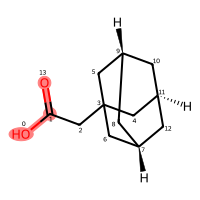
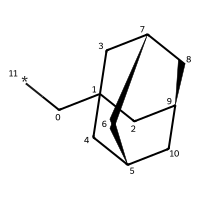
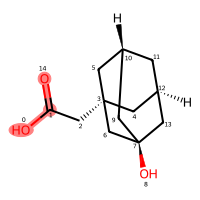
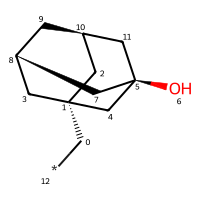
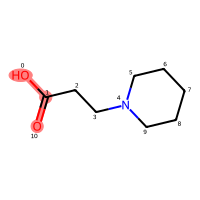
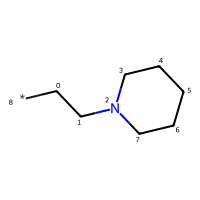

In [13]:
mol_df_D.head(3)

### 3. combine components

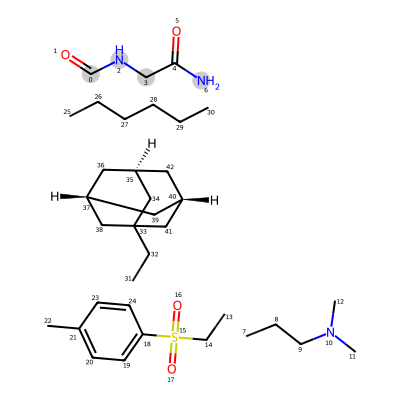

In [14]:
test_A_mol = mol_df_A["main_compoent"].iloc[0]
test_B_mol = mol_df_B["main_compoent"].iloc[1]
test_C_mol = mol_df_C["main_compoent"].iloc[0]
test_D_mol = mol_df_D["main_compoent"].iloc[0]

test_A_smiles = mol_df_A["main_compoent_SMILES"].iloc[0]
test_B_smiles = mol_df_B["main_compoent_SMILES"].iloc[1]
test_C_smiles = mol_df_C["main_compoent_SMILES"].iloc[0]
test_D_smiles = mol_df_D["main_compoent_SMILES"].iloc[0]
assert test_A_smiles.startswith("*")
assert test_B_smiles.startswith("*")
assert test_C_smiles.startswith("*")
assert test_D_smiles.startswith("*")

star_of_A_pos = core_num_atoms
star_of_B_pos = core_num_atoms + test_A_mol.GetNumAtoms()
star_of_C_pos = core_num_atoms + test_A_mol.GetNumAtoms() + test_B_mol.GetNumAtoms()
star_of_D_pos = (
    core_num_atoms
    + test_A_mol.GetNumAtoms()
    + test_B_mol.GetNumAtoms()
    + test_C_mol.GetNumAtoms()
)

mol_to_combine = Chem.MolFromSmiles(
    f"{core_smiles}.{test_A_smiles}.{test_B_smiles}.{test_C_smiles}.{test_D_smiles} |m:{star_of_A_pos}:{core_A_pos},{star_of_B_pos}:{core_B_pos},{star_of_C_pos}:{core_C_pos},{star_of_D_pos}:{core_D_pos}|"
)

# show_atom_number(mol_to_combine, "atomLabel")
Draw.MolToImage(show_atom_number(mol_to_combine), size=(400, 400))

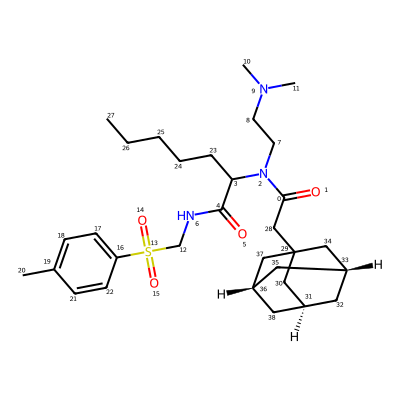

In [15]:
Draw.MolToImage(
    show_atom_number(rdMolEnumerator.Enumerate(mol_to_combine)[0]),
    size=(400, 400),
)

### 4. Generate all molecules

In [16]:
combined_mols = []
count = 0
for i in range(len(mol_df_A)):
    test_A_mol, raw_A_mol, test_A_smiles, raw_A_smiles = mol_df_A.iloc[i][
        ["main_compoent", "mol", "main_compoent_SMILES", "SMILES"]
    ]
    for j in range(len(mol_df_B)):
        test_B_mol, raw_B_mol, test_B_smiles, raw_B_smiles = mol_df_B.iloc[j][
            ["main_compoent", "mol", "main_compoent_SMILES", "SMILES"]
        ]
        for k in range(len(mol_df_C)):
            test_C_mol, raw_C_mol, test_C_smiles, raw_C_smiles = mol_df_C.iloc[k][
                ["main_compoent", "mol", "main_compoent_SMILES", "SMILES"]
            ]
            for l in range(len(mol_df_D)):
                test_D_mol, raw_D_mol, test_D_smiles, raw_D_smiles = mol_df_D.iloc[l][
                    ["main_compoent", "mol", "main_compoent_SMILES", "SMILES"]
                ]
                if count % 10000 == 0:
                    print(f"Generating the No.{count} molecule")

                assert test_A_smiles.startswith("*")
                assert test_B_smiles.startswith("*")
                assert test_C_smiles.startswith("*")
                assert test_D_smiles.startswith("*")

                star_of_A_pos = core_num_atoms
                star_of_B_pos = core_num_atoms + test_A_mol.GetNumAtoms()
                star_of_C_pos = (
                    core_num_atoms + test_A_mol.GetNumAtoms() + test_B_mol.GetNumAtoms()
                )
                star_of_D_pos = (
                    core_num_atoms
                    + test_A_mol.GetNumAtoms()
                    + test_B_mol.GetNumAtoms()
                    + test_C_mol.GetNumAtoms()
                )

                mol_to_combine = Chem.MolFromSmiles(
                    f"{core_smiles}.{test_A_smiles}.{test_B_smiles}.{test_C_smiles}.{test_D_smiles} |m:{star_of_A_pos}:{core_A_pos},{star_of_B_pos}:{core_B_pos},{star_of_C_pos}:{core_C_pos},{star_of_D_pos}:{core_D_pos}|"
                )

                enumerated = rdMolEnumerator.Enumerate(mol_to_combine)
                assert len(enumerated) == 1
                combined_mol = enumerated[0]

                results = {}
                results["id"] = count
                results["combined_mol"] = combined_mol
                results["combined_mol_SMILES"] = Chem.MolToSmiles(combined_mol)
                # TODO: potentially also add the raw components
                results["A"] = raw_A_mol
                results["A_smiles"] = raw_A_smiles
                results["B"] = raw_B_mol
                results["B_smiles"] = raw_B_smiles
                results["C"] = raw_C_mol
                results["C_smiles"] = raw_C_smiles
                results["D"] = raw_D_mol
                results["D_smiles"] = raw_D_smiles

                combined_mols.append(results)
                count = count + 1

Generating the No.0 molecule


Generating the No.10000 molecule
Generating the No.20000 molecule
Generating the No.30000 molecule
Generating the No.40000 molecule
Generating the No.50000 molecule
Generating the No.60000 molecule
Generating the No.70000 molecule
Generating the No.80000 molecule
Generating the No.90000 molecule
Generating the No.100000 molecule
Generating the No.110000 molecule
Generating the No.120000 molecule
Generating the No.130000 molecule
Generating the No.140000 molecule
Generating the No.150000 molecule
Generating the No.160000 molecule
Generating the No.170000 molecule
Generating the No.180000 molecule
Generating the No.190000 molecule
Generating the No.200000 molecule
Generating the No.210000 molecule
Generating the No.220000 molecule


In [17]:
combined_df = pd.DataFrame(combined_mols)

,id,combined_mol,combined_mol_SMILES,A,A_smiles,B,B_smiles,C,C_smiles,D,D_smiles
0,0,,CCCCCC(C(=O)NC)N(CCN(C)C)C(=O)CC12C[C@H]3C[C@@...,,NCCN(C)C,,C[N+]#[C-],,CCCCCC=O,,OC(CC(C1)(C2)C[C@@H]3C[C@H]2C[C@H]1C3)=O
1,1,,CCCCCC(C(=O)NC)N(CCN(C)C)C(=O)C[C@@]12C[C@@H]3...,,NCCN(C)C,,C[N+]#[C-],,CCCCCC=O,,OC(C[C@@](C1)(C2)C[C@]3(O)C[C@H]2C[C@H]1C3)=O
2,2,,CCCCCC(C(=O)NC)N(CCN(C)C)C(=O)CCN1CCCCC1,,NCCN(C)C,,C[N+]#[C-],,CCCCCC=O,,OC(CCN1CCCCC1)=O

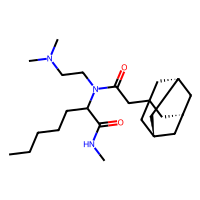
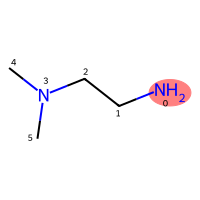
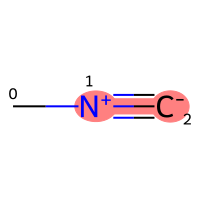
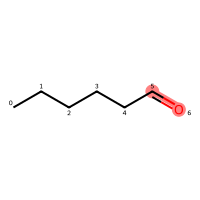
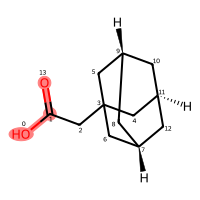
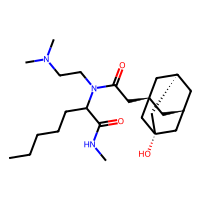
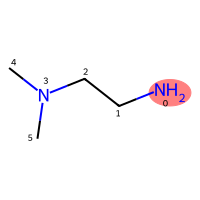
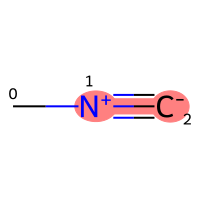
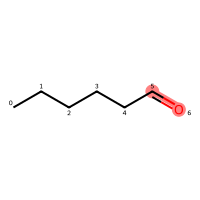
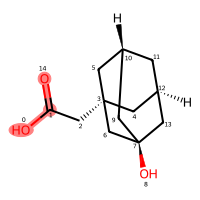
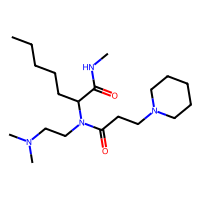
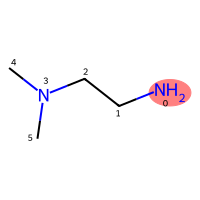
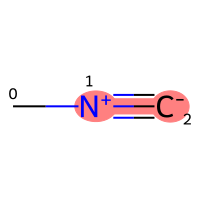
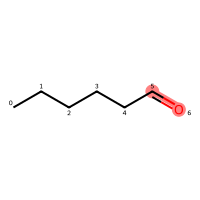
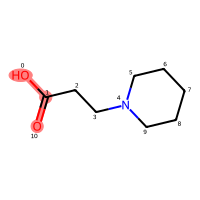

In [18]:
combined_df.head(3)

In [19]:
# only include the columns that can be saved in csv before saving
combined_df[
    ["id", "combined_mol_SMILES", "A_smiles", "B_smiles", "C_smiles", "D_smiles"]
].to_csv("220k_library.csv", index=False)